# Customer Segmentation and Purchase Analysis

<img src='main.webp'>
<a href="https://www.freepik.com/free-vector/audience-segmentation-abstract-concept-illustration_11667653.htm#query=customer%20analysis&position=1&from_view=search">Image by vectorjuice</a> on Freepik

## Objectives
  *  Customer Segmentation
  *  Descriptive and Prescriptive study of customers purchasing behaviour.
  *  Modeling Buy incidence, Brand preference, and Purchase quantity.

## Packages

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Import Data

In [2]:
customers = pd.read_csv('customers.csv',index_col=0)

## Explore Data

In [3]:
profile = ProfileReport(customers, title="Customers Profiling Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* Two Numerical Cols > Age and Income
* Rest of the columns are categorical
* High Correletaion between Age and Eduation
* Sex is highly correlated with Marital status

### Descriptive Stats

In [4]:
customers.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


### Age and Income

<Figure size 864x648 with 0 Axes>

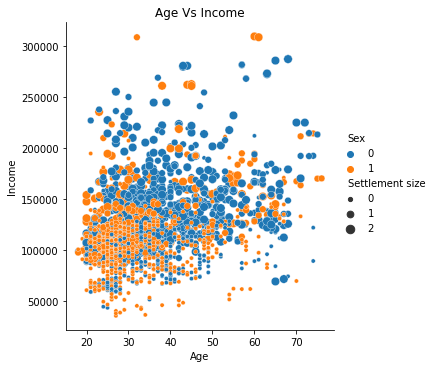

In [5]:
plt.figure(figsize = (12, 9))
sns.relplot(data=customers,x='Age',y='Income',hue='Sex',size='Settlement size')
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Age Vs Income');

### Outliers In Numerical Columns

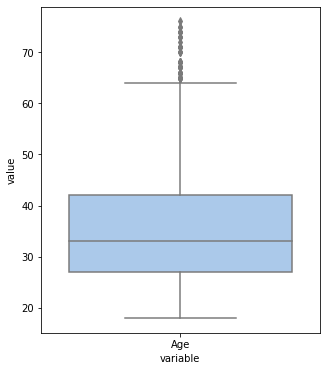

In [6]:
plt.figure(figsize=(5,6))
sns.boxplot(x="variable",y="value",data=pd.melt(customers[['Age']]),palette="pastel");

*  Outliers in age above 65

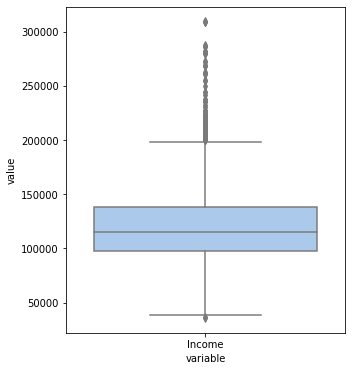

In [7]:
plt.figure(figsize=(5,6))
sns.boxplot(x="variable",y="value",data=pd.melt(customers[['Income']]),palette="pastel");

* Income above 200,000 is Outlier

## Clustering with PCA

### Data Preprocessing

In [8]:
scaler = StandardScaler()
customers_std = scaler.fit_transform(customers)

### PCA

In [9]:
pca = PCA()
pca.fit(customers_std)

PCA()

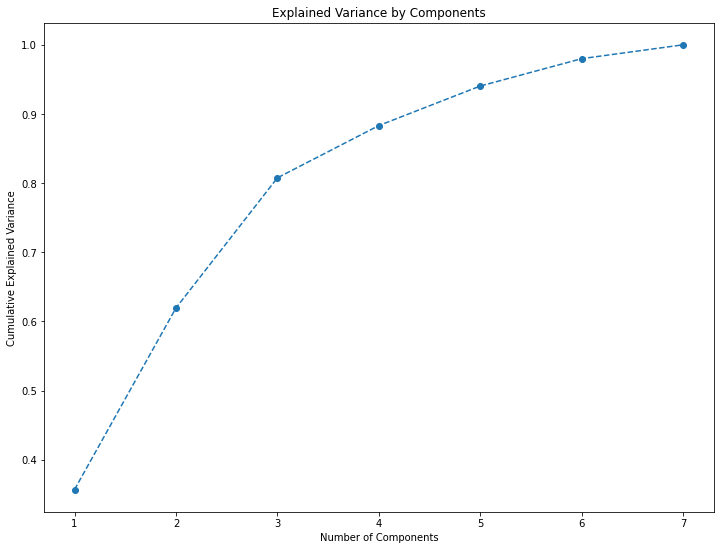

In [10]:
# PCA Explained Variance
plt.figure(figsize = (12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

* We see that 3 components can explain a varaince of more than 80%

In [11]:
# Fitting PCA with 3 components
pca = PCA(n_components = 3)
pca.fit(customers_std)

PCA(n_components=3)

### PCA Results

In [12]:
customers_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = customers.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3'])
customers_pca_comp.style.background_gradient(cmap=sns.light_palette("green", as_cmap=True),axis=0)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


* Component 1 strictly correlate with Age, Income, Occupation and Settlement size
* Component 2 strictly correlate with Sex, Marital Status and Education
* Component 3 strictly correlate with Marital Status, Age and Occupation

In [13]:
customers_pca = pca.transform(customers_std)

### K-Means Clustering

In [14]:
# Elbow Method for finding best number of cluster
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(customers_pca)
    wcss.append(kmeans_pca.inertia_)

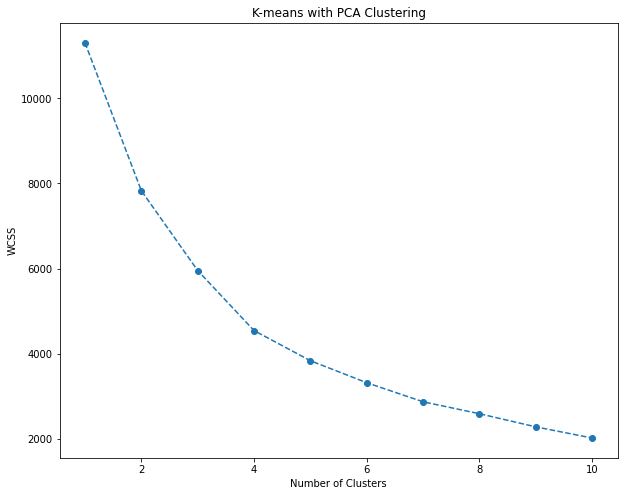

In [15]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

* 4 is optimal choice for numbers of clusters 

### K-means Clustering with PCA

In [16]:
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [17]:
kmeans_pca.fit(customers_pca)

KMeans(n_clusters=4, random_state=42)

In [18]:
# Adding segment labels to dataframe
customers_segm = pd.concat([customers.reset_index(drop = True), pd.DataFrame(customers_pca)], axis = 1)
customers_segm.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
customers_segm['Segment'] = kmeans_pca.labels_

In [19]:
customers_segm

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,3
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,2
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,1
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,1
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,2
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,0
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,2
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,0


In [20]:
customers_segm_freq = customers_segm.groupby(['Segment']).mean()
customers_segm_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment,,,,,,,,,,
0,0.900289,0.965318,28.878613,1.060694,107551.500000,0.677746,0.440751,-1.107019,0.703776,-0.781410
1,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046
2,0.306522,0.095652,35.313043,0.760870,93692.567391,0.252174,0.039130,-1.046406,-0.902963,1.003644
3,0.505660,0.690566,55.679245,2.128302,158019.101887,1.120755,1.101887,1.687328,2.031200,0.844039


In [21]:
# Number of persons in each segment and proportion of customers
customers_segm_freq['N Obs'] = customers_segm[['Segment','Sex']].groupby(['Segment']).count()
customers_segm_freq['Prop Obs'] = customers_segm_freq['N Obs'] / customers_segm_freq['N Obs'].sum()
customers_segm_freq = customers_segm_freq.rename({0:'standard', 
                                                          1:'career focused',
                                                          2:'fewer opportunities', 
                                                          3:'well-off'})
customers_segm_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment,,,,,,,,,,,,
standard,0.900289,0.965318,28.878613,1.060694,107551.500000,0.677746,0.440751,-1.107019,0.703776,-0.781410,692,0.3460
career focused,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046,583,0.2915
fewer opportunities,0.306522,0.095652,35.313043,0.760870,93692.567391,0.252174,0.039130,-1.046406,-0.902963,1.003644,460,0.2300
well-off,0.505660,0.690566,55.679245,2.128302,158019.101887,1.120755,1.101887,1.687328,2.031200,0.844039,265,0.1325


In [22]:
# Adding Segments names to dataframe
customers_segm['Legend'] = customers_segm['Segment'].map({0:'standard', 
                                                          1:'career focused',
                                                          2:'fewer opportunities', 
                                                          3:'well-off'})

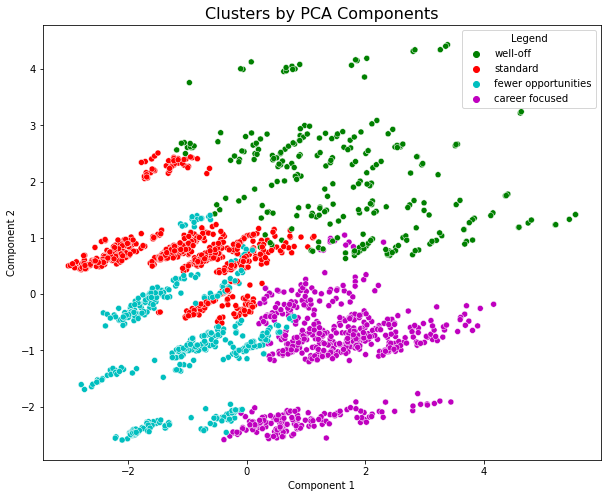

In [23]:
plt.figure(figsize = (10, 8))
sns.scatterplot(data=customers_segm,x='Component 1',y='Component 2', hue = 'Legend', palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components',fontsize=16)
plt.show()

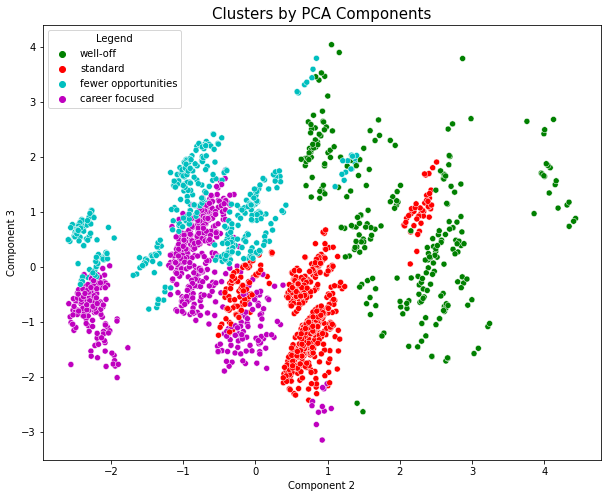

In [24]:
plt.figure(figsize = (10, 8))
sns.scatterplot(data=customers_segm,x='Component 2',y='Component 3', hue = 'Legend', palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components',fontsize=15)
plt.show()

### Data Export

In [27]:
import joblib

In [29]:
joblib.dump(scaler,'scaler.jbl')
joblib.dump(pca,'pca.jbl')
joblib.dump(kmeans_pca, 'kmeans_pca.jbl')

['kmeans_pca.jbl']